In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy.stats as st
from astropy.stats import LombScargle
import astropy.convolution as cv
from astropy.io import fits
sns.set_context('notebook')
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)
import pymc3 as pm

In [3]:
lc = pd.read_table('data/kplr007107778_kasoc-ts_slc_v1.dat', sep='\s+', comment='#', names=['time', 'flux', 'flux_error'], dtype='f8')
psd = pd.read_table('data/kplr007107778_kasoc-psd_slc_v1.pow', sep='\s+', comment='#', names=['freq', 'power'], dtype='f8')

In [13]:
mask = psd['freq'] > 12
full_freq = psd['freq'][mask].values
power = psd['power'][mask].values
fstep = 5
freq = np.arange(min(full_freq), max(full_freq), fstep)
itrp_power = np.interp(freq, full_freq, power)
smoothed_power = cv.convolve(itrp_power, cv.Box1DKernel(6 / fstep))

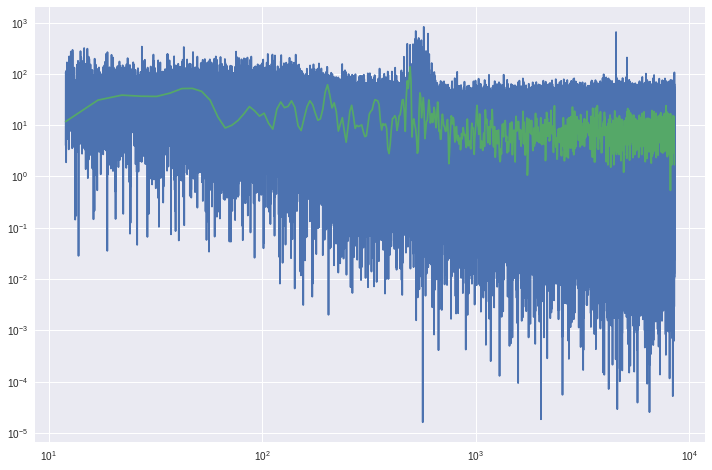

In [14]:
plt.loglog(full_freq, power)
plt.loglog(freq, smoothed_power);

In [27]:

with pm.Model() as max_model:
    v_nyq = 8496.36
    R_v = (pm.math.sin( np.pi * freq / (2 * v_nyq)) / ((np.pi * freq) / (2 * v_nyq)))**2
    k = 3
    
    W = pm.Bound(pm.Normal, lower=0)('W', mu=12, sd=1)
    
    a = pm.Normal('a', mu=np.array([59, 67, 76]).reshape(k,1), sd=8, shape=(k,1))
    b = pm.Normal('b', mu=np.array([5, 150, 400]).reshape(k,1), sd=np.array([1, 32, 64]).reshape(k,1), shape=(k,1))
    
    harv = pm.math.sum(2 * pm.math.sqrt(2) / np.pi * (a**2 / b) / (1 + (freq/b)**4), axis=0)
    
    H0 = pm.Bound(pm.Normal, lower=0)('H0', mu=18, sd=3)
    v_max = pm.Bound(pm.Normal, lower=0)('v_max', mu=568, sd=8)
    s = pm.InverseGamma('s', alpha=41, beta=2225)
    env = H0 * pm.math.exp(-(freq - v_max)**2) / (2 * s**2)
    
    like = W + R_v * (harv + env)
    e = pm.HalfCauchy('e', 10)
    y = pm.Normal('obs', mu=like, sd=e, observed=smoothed_power)
    

In [28]:
with max_model:
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_log__, s_log__, v_max_lowerbound__, H0_lowerbound__, b, a, W_lowerbound__]
100%|██████████| 3000/3000 [00:26<00:00, 112.64it/s]


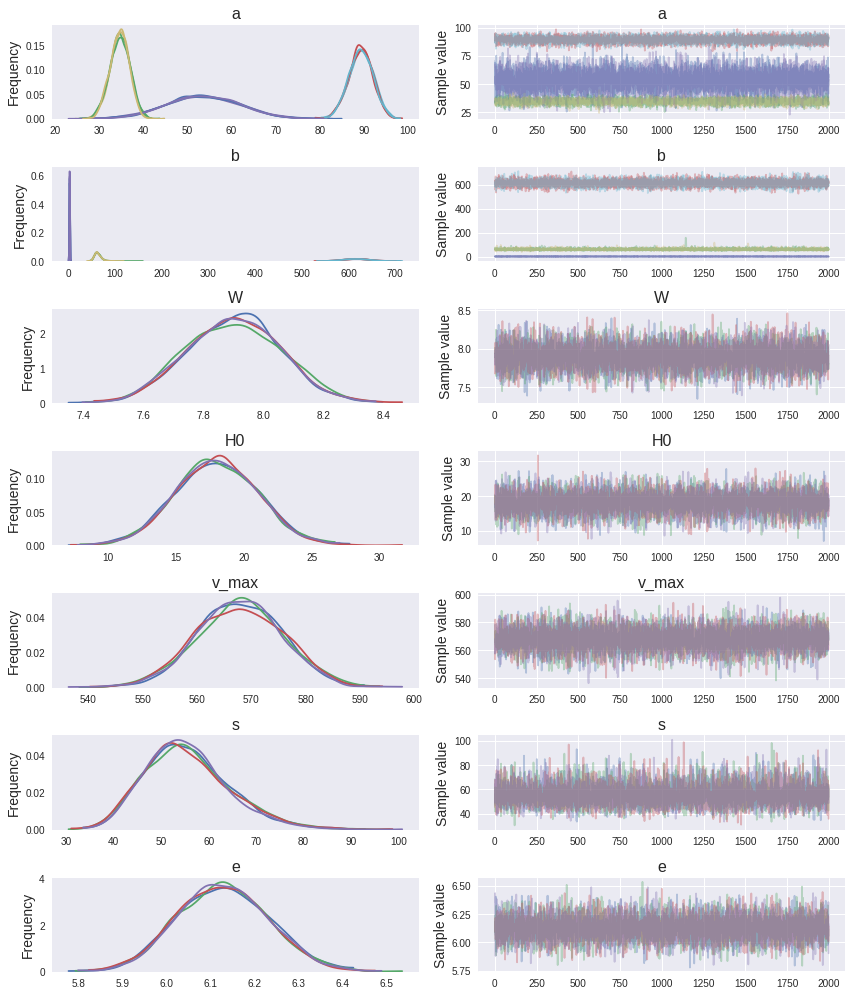

In [29]:
pm.traceplot(trace);

In [30]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a__0_0,53.521637,8.326718,0.090429,37.588677,70.325578,8000.0,0.999809
a__1_0,34.646763,2.248411,0.019937,30.183155,38.972109,8000.0,0.999851
a__2_0,89.304068,2.727428,0.027069,83.691904,94.342956,8000.0,1.000083
b__0_0,2.745485,0.672867,0.006866,1.383720,4.046197,8000.0,0.999895
b__1_0,62.999708,7.322763,0.093305,50.180528,76.752299,6165.0,1.000130
b__2_0,615.282255,25.930252,0.190531,564.463989,666.255967,8000.0,0.999862
W,7.899085,0.156951,0.001177,7.588499,8.195814,8000.0,0.999801
H0,17.966240,3.015972,0.028644,12.186803,23.893639,8000.0,0.999869
v_max,567.899075,7.974753,0.076465,552.516490,583.601626,8000.0,0.999834
s,55.532670,8.981047,0.088203,39.358540,73.612443,8000.0,1.000051


In [31]:
ppc = pm.sample_ppc(trace, 1000, max_model)
post = ppc['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:03<00:00, 250.30it/s]


In [32]:
def harvey(v, a, b):
    return 2 * np.sqrt(2) / np.pi * (a**2 / b) / (1 + (v/b)**4)

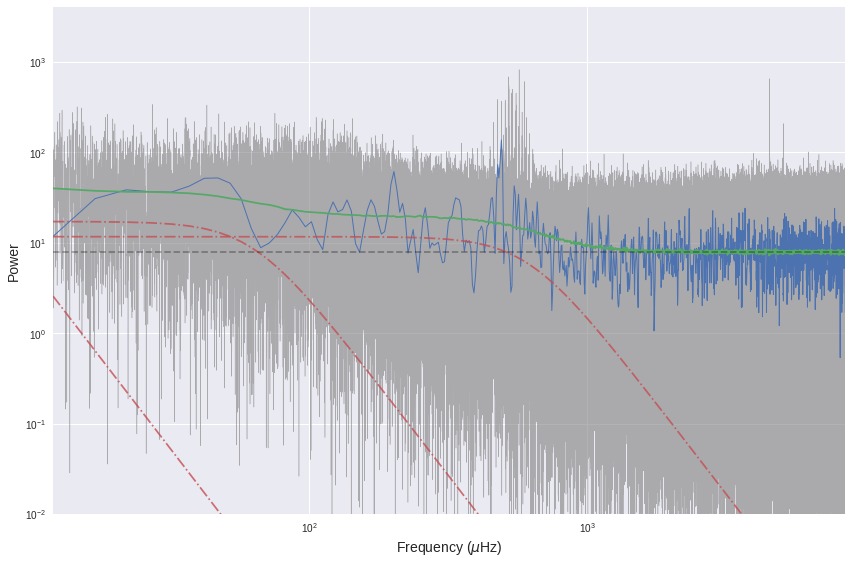

In [34]:
plt.loglog(full_freq, power, lw=.5, alpha=.6, c='.5')
plt.loglog(freq, smoothed_power, 'C0', lw=1)
plt.loglog(freq, post, 'C1')
# plt.axvline(trace['v_max'].mean(), c='k', ls='--')
a = trace.get_values('a').mean(axis=0)
b = trace.get_values('b').mean(axis=0)
[plt.loglog(freq, harv, 'C2-.', alpha=.8) for harv in harvey(freq, a, b)]
plt.axhline(trace.get_values('W').mean(), c='k', alpha=.3, ls='--')
plt.ylim(1e-2, None)
plt.xlim(min(freq), max(freq))
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout();

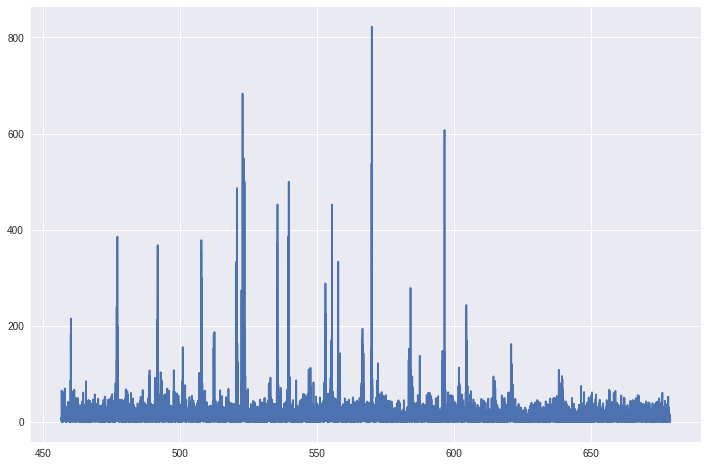

In [60]:
s = trace.get_values('s').mean(axis=0)
v_max = trace.get_values('v_max').mean(axis=0)
mask = (full_freq > (v_max - 2 * s)) & (full_freq < (v_max + 2 * s))
subfreq = full_freq[mask]
subpower = power[mask]
plt.plot(subfreq, subpower)

(1000,)


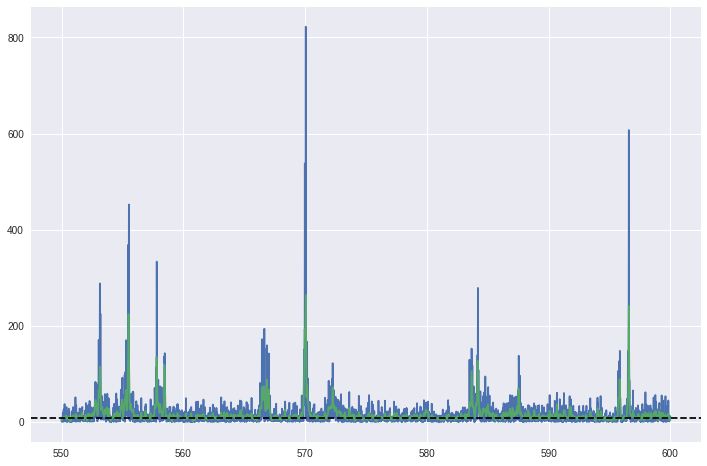

In [116]:
mask = (full_freq > 550) & (full_freq < 600)
ff = full_freq[mask]
pp = power[mask]

fstep = ff[1]-ff[0]
subfreq = np.linspace(min(ff), max(ff), 1000)
smp = cv.convolve(pp, cv.Box1DKernel(4))
subpower = np.interp(subfreq, ff, smp)

print(subpower.shape)
plt.plot(ff, pp)
plt.plot(subfreq, subpower)
plt.axhline(trace.get_values('W').mean(axis=0), ls='--', c='k')

In [120]:
modes = np.array([552, 555, 558, 567, 570, 572, 584, 587, 597, 598])
n = len(modes)
with pm.Model() as mode_model:
    A = pm.Normal('A', mu=20, sd=15, shape=(n,1))
    v0 = pm.Normal('v0', mu=modes.reshape(n,1), sd=10, shape=(n,1))
#     L = pm.Bound(pm.Normal, lower=0)('L', mu=.12, sd=1, shape=(n,1))
    L = pm.HalfCauchy('L', 1, shape=(n,1))
    R_v = (pm.math.sin( np.pi * subfreq / (2 * v_nyq)) / ((np.pi * subfreq) / (2 * v_nyq)))**2
    
    e = pm.HalfCauchy('e', 10)
    
    like = pm.math.sum(R_v * (A**2 / (np.pi * L)) / (1 + 4 * ( subfreq - v0)**2 / L**2), axis=0) + trace['W'].mean()
    
    y = pm.Normal('obs', mu=like, sd=e, observed=subpower)

In [121]:
with mode_model:
    mode_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_log__, L_log__, v0, A]
100%|██████████| 1500/1500 [07:52<00:00,  3.18it/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43698241319877074, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 565 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34266402944516405, but sh

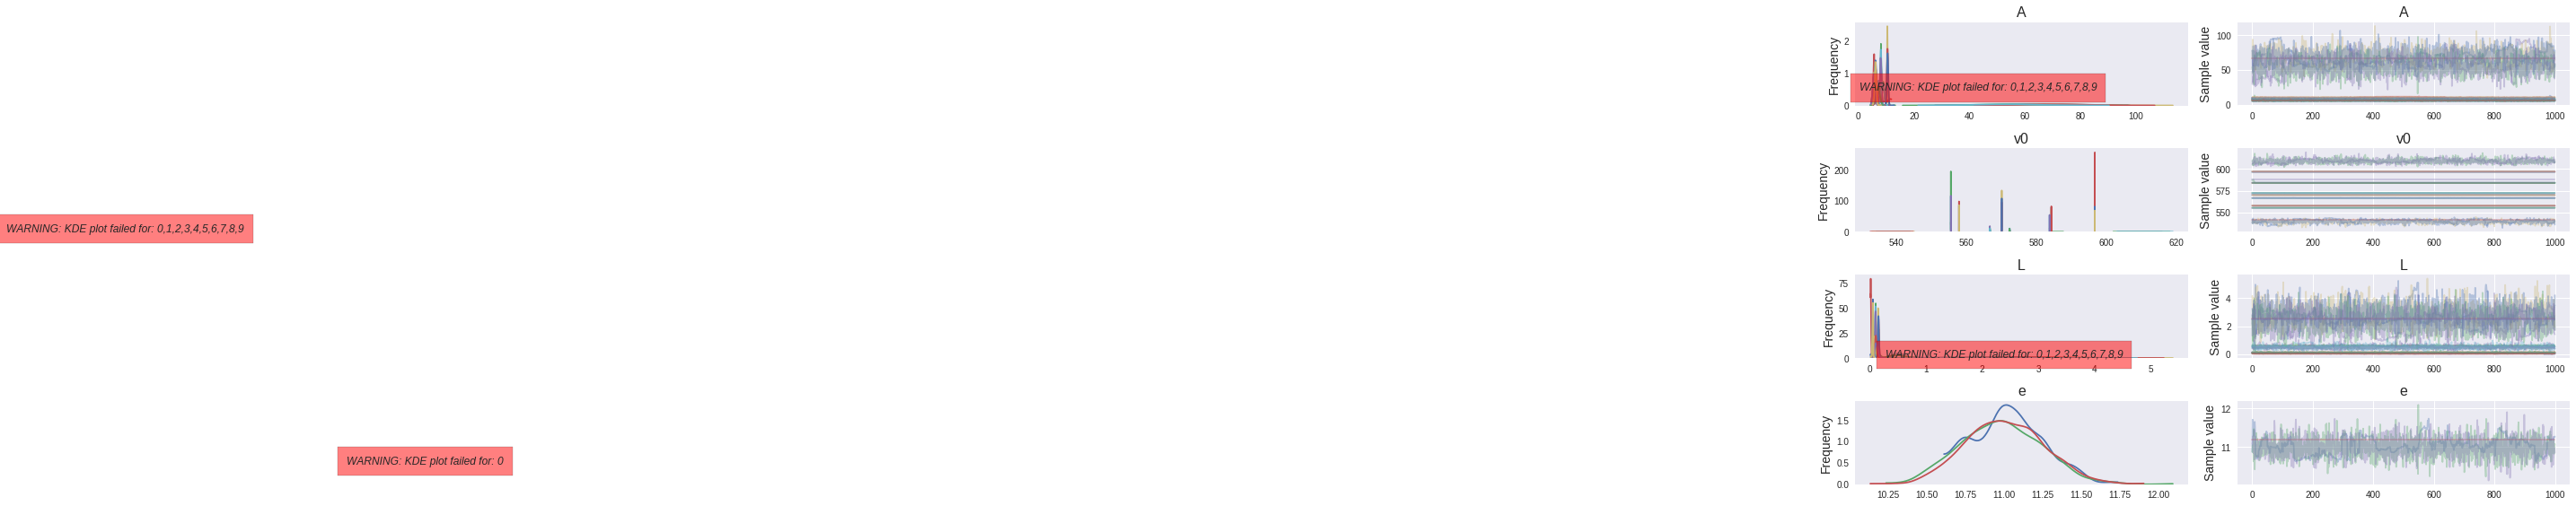

In [119]:
pm.traceplot(mode_trace);

In [87]:
prof = pm.sample_ppc(mode_trace, 1000, mode_model)['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:01<00:00, 599.97it/s]


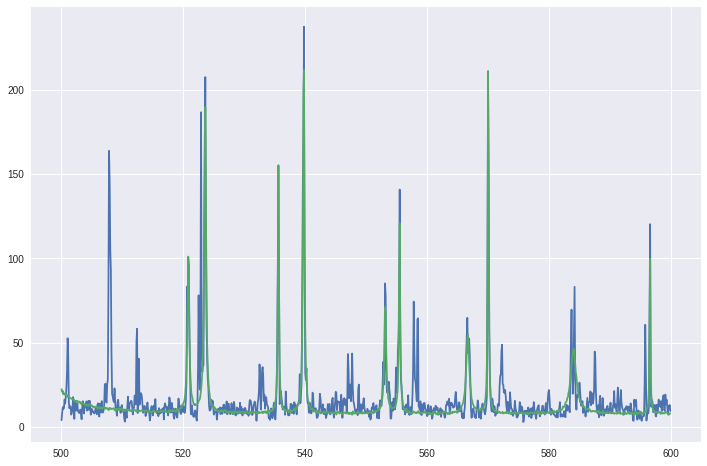

In [88]:
plt.plot(subfreq, subpower)
plt.plot(subfreq, prof, 'C1')